In [1]:
# In order to force the reload of modules
%load_ext autoreload
%autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import heapq
import numpy as np
from typing import *

from ml.rl.core import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
"""
Trying the agent on cartpole
"""


def try_agent(agent: Agent):
    with gym.make("CartPole-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print("Total reward {0:.2f}".format(total_reward))


"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


try_agent(RandomAgent())

Total reward 19.00


In [3]:
"""
Manual agent (does not take account of speed)
"""


class BrutalAgent(Agent):
    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        if theta < 0.02:
            return 0
        elif theta > 0.02:
            return 1
        return 0


try_agent(BrutalAgent())

Total reward 48.00


In [4]:
"""
Application of PID circuit (limited to linear systems)
"""


# How you do it in the industry
print("TODO")

TODO


Mean score: 31.375
Mean score: 34.9375
Mean score: 39.5
Mean score: 46.8125
Mean score: 69.625
Mean score: 46.8125
Mean score: 69.375
Mean score: 92.1875
Mean score: 110.0
Mean score: 111.5
Mean score: 106.125
Mean score: 97.625
Mean score: 121.375
Mean score: 107.375
Mean score: 134.25
Mean score: 151.8125
Mean score: 185.9375
Mean score: 200.0
Solved!


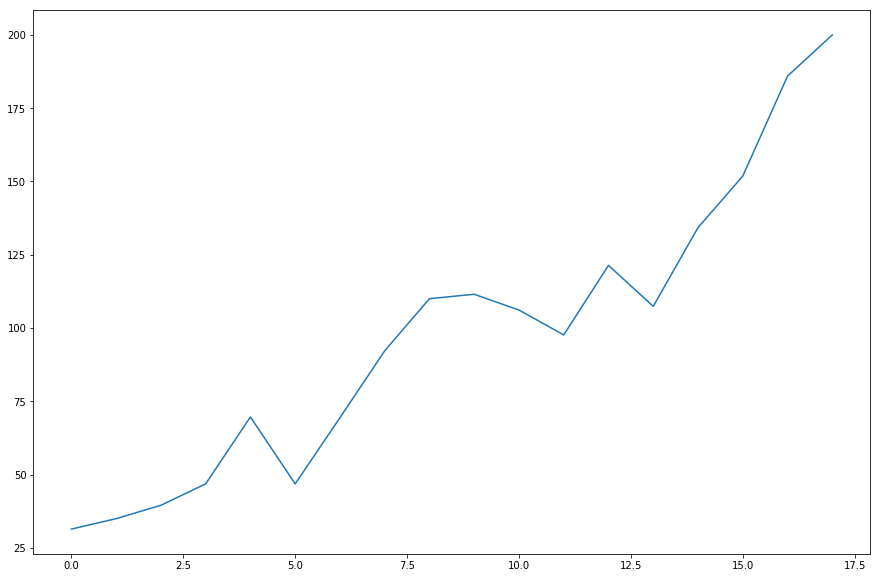

In [5]:
"""
Cross Entropy Method:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)
=> Look like a kind of genetic algorithm stuff
"""


from ml.rl.cross_entropy_method import *


"""
Implementation of a policy to learn via a Neural Net
"""


class FullyConnectedNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys
    

"""
Test with the policy of a neural net
"""


fc_net = FullyConnectedNet(observation_size=4, hidden_size=100, action_size=2)
policy = NeuralNetPolicy(iteration_nb=5, learning_rate=0.1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

Mean score: 25.25
Mean score: 38.9375
Mean score: 41.1875
Mean score: 61.8125
Mean score: 93.375
Mean score: 128.6875
Mean score: 170.5625
Mean score: 200.0
Solved!


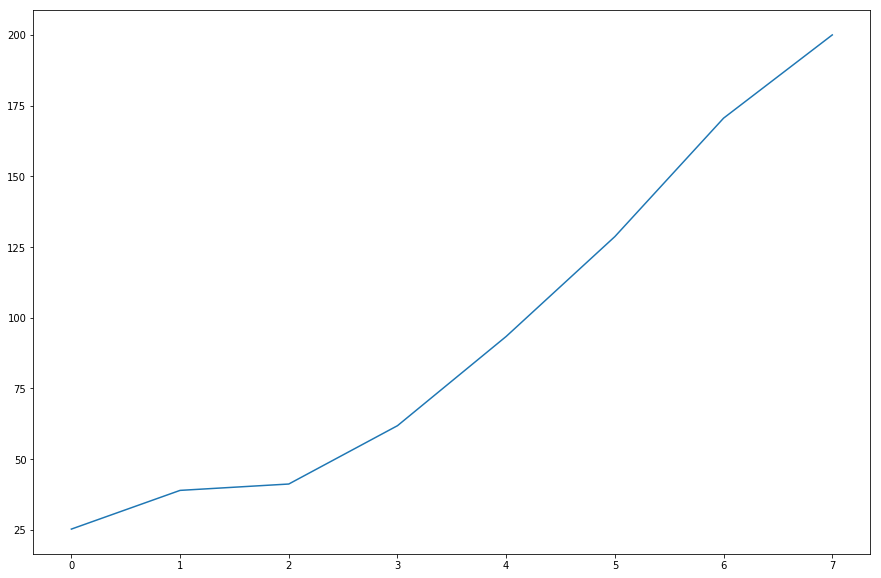

In [6]:
class PolynomialRegressionNet(nn.Module):
    def __init__(self, observation_size, action_size):
        super().__init__()
        feature_size = self._transform(torch.zeros(observation_size)).shape[0]
        self.fc = nn.Linear(feature_size, action_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax=False):
        if len(observations.shape) == 2:
            xs = torch.stack([self._transform(observation) for observation in observations])
        else:
            xs = self._transform(observations)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys)
        return ys
    
    def _transform(self, observation):
        xs = list(observation)
        k = len(observation)
        for i in range(k-1):
            for j in range(i+1, k):
                xs.append(observation[i] * observation[j])
        return torch.FloatTensor(xs)
    

"""
Test with the policy of a neural net
"""


fc_net = PolynomialRegressionNet(observation_size=4, action_size=2)
policy = NeuralNetPolicy(iteration_nb=5, learning_rate=0.1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

In [14]:
"""
With Deep Q-Learning
"""


from ml.rl.deep_q_learning import *


class RegressionNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))

    def forward(self, observations):
        ys = self.fc(observations)
        return ys

    
"""
Try the Deep Q learning agent
"""


start_epsilon = 0.3
end_epsilon = 0.1

policy_net=RegressionNet(4, 100, 2)

agent = DeepQLearningAgent(
    q_values=NeuralNetQValues(net=policy_net, iteration_nb=10, learning_rate=1e-2),
    start_epsilon=start_epsilon,
    min_epsilon=end_epsilon)

with gym.make("CartPole-v0") as env:
    max_iterations = 100
    scores = agent.fit(env,
                       is_success = lambda score: score == 200,
                       max_episodes = 10_000,
                       replay_buffer_size = 100,
                       replay_start_size = 100,
                       batch_size = 16,
                       policy_improvement_size = 16,
                       epsilon_decrease_factor = 0.99)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

# 16 Mean score: 10.5625 (epsilon: 0.3 )
# 32 Mean score: 12.1875 (epsilon: 0.3 )
# 48 Mean score: 15.125 (epsilon: 0.3 )
# 64 Mean score: 10.5 (epsilon: 0.3 )
# 80 Mean score: 22.25 (epsilon: 0.3 )
# 96 Mean score: 13.9375 (epsilon: 0.3 )
# 112 Mean score: 10.8125 (epsilon: 0.3 )
# 128 Mean score: 12.9375 (epsilon: 0.3 )
# 144 Mean score: 11.8125 (epsilon: 0.3 )
# 160 Mean score: 12.125 (epsilon: 0.3 )
# 176 Mean score: 11.8125 (epsilon: 0.3 )
# 192 Mean score: 11.4375 (epsilon: 0.3 )
# 208 Mean score: 11.3125 (epsilon: 0.3 )
# 224 Mean score: 10.9375 (epsilon: 0.3 )
# 240 Mean score: 10.25 (epsilon: 0.3 )
# 256 Mean score: 13.875 (epsilon: 0.3 )
# 272 Mean score: 11.4375 (epsilon: 0.3 )
# 288 Mean score: 11.3125 (epsilon: 0.3 )
# 304 Mean score: 11.5625 (epsilon: 0.3 )
# 320 Mean score: 30.875 (epsilon: 0.3 )
# 336 Mean score: 12.1875 (epsilon: 0.3 )
# 352 Mean score: 9.75 (epsilon: 0.3 )
# 368 Mean score: 11.4375 (epsilon: 0.3 )
# 384 Mean score: 12.0 (epsilon: 0.3 )
# 400 Mean scor

KeyboardInterrupt: 